## Naimportovaný marek.coderslab@gmail.com.ics z Google Calendar

In [3]:
import pandas as pd
from icalendar import Calendar

# Načti ICS soubor
with open("marek.coderslab@gmail.com.ics", "rb") as f:
    gcal = Calendar.from_ical(f.read())

events = []
for component in gcal.walk():
    if component.name == "VEVENT":
        events.append({
            "summary": str(component.get("summary")),
            "start": component.get("dtstart").dt,
            "end": component.get("dtend").dt,
            "description": str(component.get("description")),
            "location": str(component.get("location"))
        })

df = pd.DataFrame(events)
print(df.head())


       summary                     start                       end  \
0  TOPFit: ZRT 2025-07-14 13:00:00+00:00 2025-07-14 14:00:00+00:00   
1   TOPFit: PB 2025-07-17 12:00:00+00:00 2025-07-17 13:00:00+00:00   
2  TOPFit: ZRT 2025-07-07 13:00:00+00:00 2025-07-07 14:00:00+00:00   
3   TOPFit: PB 2025-07-10 12:00:00+00:00 2025-07-10 13:00:00+00:00   
4  TOPFit: ZRT 2025-06-30 12:45:00+00:00 2025-06-30 13:45:00+00:00   

  description location  
0        None     None  
1        None     None  
2        None     None  
3        None     None  
4        None     None  


In [2]:
# !pip install icalendar


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


# Kód při stažení .zip s .ics z Export calendar "Marek.Coderslab"

In [14]:
import pandas as pd
from icalendar import Calendar
import zipfile
import re

zip_path = "marek.coderslab@gmail.com.ical.zip"

# otevřeme ZIP a najdeme ICS soubor
with zipfile.ZipFile(zip_path, "r") as z:
    # najdi soubor končící na .ics (pokud jich je víc, vezme první)
    ics_name = [f for f in z.namelist() if f.endswith(".ics")][0]
    with z.open(ics_name) as f:
        gcal = Calendar.from_ical(f.read())

events = []
for component in gcal.walk():
    if component.name == "VEVENT":
        summary = str(component.get("summary") or "")

        # odstraň prefix "TOPFIT:" bez ohledu na velikost
        clean_summary = re.sub(r"^\s*TOPFIT:\s*", "", summary, flags=re.IGNORECASE).strip()

        start = component.get("dtstart").dt
        end = component.get("dtend").dt

        events.append({
            "summary": clean_summary,
            "start": start,
            "end": end
        })

df_topfit = pd.DataFrame(events)

# jen datum
df_topfit["date"] = pd.to_datetime(df_topfit["start"]).dt.date

# délka v minutách
df_topfit["doba"] = (df_topfit["end"] - df_topfit["start"]).dt.total_seconds() / 60

# vyber sloupce a seřaď od nejnovějšího
df_topfit = df_topfit[["date", "summary", "doba"]].sort_values("date", ascending=False).reset_index(drop=True)

print(df_topfit.head(20))


          date            summary  doba
0   2025-08-28                ZRT  60.0
1   2025-08-21                 PB  60.0
2   2025-08-18                ZRT  60.0
3   2025-08-14                 PB  60.0
4   2025-08-11                ZRT  60.0
5   2025-08-07       Nohy, břicho  60.0
6   2025-08-04  PB - roztrž. ruky  60.0
7   2025-07-31                ZRT  60.0
8   2025-07-24                 PB  60.0
9   2025-07-22                ZRT  60.0
10  2025-07-17                 PB  60.0
11  2025-07-14                ZRT  60.0
12  2025-07-10                 PB  60.0
13  2025-07-07                ZRT  60.0
14  2025-07-03                 PB  60.0
15  2025-06-30                ZRT  60.0
16  2025-06-26                 PB  60.0


In [15]:
# !pip install google-api-python-client google-auth-httplib2 google-auth-oauthlib pandas


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 3.0 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


# Kód využívající přímé připojení na Google calendar API

In [3]:
import os
import pandas as pd
import re
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from datetime import datetime

# Scope: jen čtení kalendáře
SCOPES = ["https://www.googleapis.com/auth/calendar.readonly"]

# Funkce pro získání service objektu
def get_service():
    creds = None
    if os.path.exists("token.json"):
        creds = Credentials.from_authorized_user_file("token.json", SCOPES)
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file("client_secret_1058953791301-pucaisjv7jacmllg5igtsftqlui6qmgd.apps.googleusercontent.com.json", SCOPES)
            creds = flow.run_local_server(port=0)
        with open("token.json", "w") as token:
            token.write(creds.to_json())
    service = build("calendar", "v3", credentials=creds)
    return service

# Funkce pro načtení událostí
def fetch_events(calendar_id, max_results=250):
    service = get_service()
    events_result = service.events().list(
        calendarId=calendar_id,
        timeMin="2000-01-01T00:00:00Z",  # začátek období
        maxResults=max_results,
        singleEvents=True,
        orderBy="startTime"
    ).execute()
    events = events_result.get("items", [])
    return events

# Funkce pro převod událostí do DataFrame
def events_to_df(events):
    rows = []
    for e in events:
        summary = e.get("summary", "")
        # odstranění TOPFIT: (case-insensitive)
        clean_summary = re.sub(r"^\s*TOPFIT:\s*", "", summary, flags=re.IGNORECASE).strip()

        start_str = e["start"].get("dateTime", e["start"].get("date"))
        end_str = e["end"].get("dateTime", e["end"].get("date"))

        start_dt = pd.to_datetime(start_str)
        end_dt = pd.to_datetime(end_str)

        duration_min = (end_dt - start_dt).total_seconds() / 60  # délka v minutách

        rows.append({
            "date": start_dt.date(),
            "summary": clean_summary,
            "doba": duration_min
        })

    df = pd.DataFrame(rows)
    df = df.sort_values("date", ascending=False).reset_index(drop=True)
    return df

# --- použití ---
calendar_id = "marek.coderslab@gmail.com"  # např. abc123@group.calendar.google.com
events = fetch_events(calendar_id)
df = events_to_df(events)

print(df)
# Uložení DataFrame do CSV
# df.to_csv("topfit_cviceni.csv", index=False, encoding="utf-8-sig")


          date             summary  doba
0   2025-08-28  ZRT - tenis. loket  60.0
1   2025-08-21   PB - tenis. loket  60.0
2   2025-08-18  ZRT - tenis. loket  60.0
3   2025-08-14                  PB  60.0
4   2025-08-11                 ZRT  60.0
5   2025-08-07        Nohy, břicho  60.0
6   2025-08-04   PB - roztrž. ruky  60.0
7   2025-07-31                 ZRT  60.0
8   2025-07-24                  PB  60.0
9   2025-07-22                 ZRT  60.0
10  2025-07-17                  PB  60.0
11  2025-07-14                 ZRT  60.0
12  2025-07-10                  PB  60.0
13  2025-07-07                 ZRT  60.0
14  2025-07-03                  PB  60.0
15  2025-06-30                 ZRT  60.0
16  2025-06-26                  PB  60.0


## Sjednocení názvů workout

In [9]:
# Sjednocení názvů lekcí
def normalize_summary(text: str) -> str:
    text = text.strip().upper()
    if text.startswith("ZRT"):
        return "ZRT"
    elif text.startswith("PB"):
        return "PB"
    elif text.startswith("NOHY"):
        return "NOHY"
    else:
        return text  # fallback, pokud by bylo něco jiného

df["summary_norm"] = df["summary"].apply(normalize_summary)


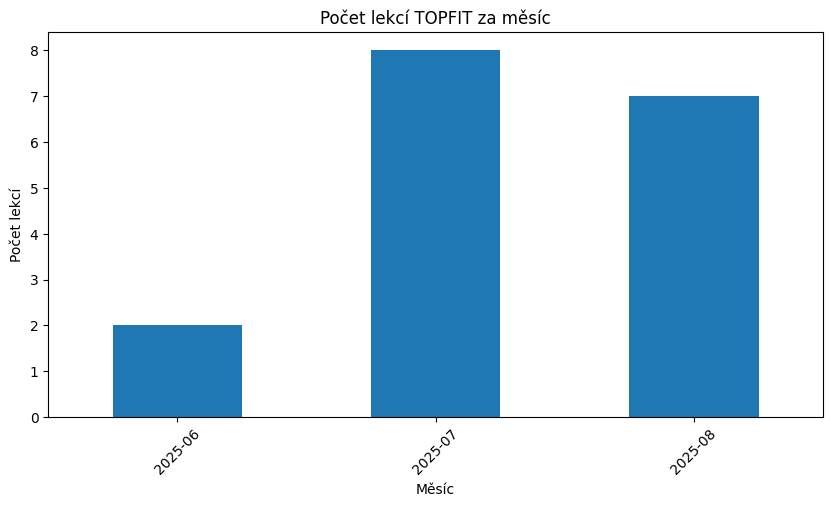

In [10]:
import matplotlib.pyplot as plt

# Počet lekcí za měsíc
df["month"] = pd.to_datetime(df["date"]).dt.to_period("M")
counts = df.groupby("month")["summary_norm"].count()

counts.plot(kind="bar", figsize=(10,5))
plt.title("Počet lekcí TOPFIT za měsíc")
plt.xlabel("Měsíc")
plt.ylabel("Počet lekcí")
plt.xticks(rotation=45)
plt.show()


In [14]:
df

,date,summary,doba,month,week,summary_norm
0,2025-08-28,ZRT - tenis. loket,60.0,2025-08,2025-08-25/2025-08-31,ZRT
1,2025-08-21,PB - tenis. loket,60.0,2025-08,2025-08-18/2025-08-24,PB
2,2025-08-18,ZRT - tenis. loket,60.0,2025-08,2025-08-18/2025-08-24,ZRT
3,2025-08-14,PB,60.0,2025-08,2025-08-11/2025-08-17,PB
4,2025-08-11,ZRT,60.0,2025-08,2025-08-11/2025-08-17,ZRT
5,2025-08-07,"Nohy, břicho",60.0,2025-08,2025-08-04/2025-08-10,NOHY
6,2025-08-04,PB - roztrž. ruky,60.0,2025-08,2025-08-04/2025-08-10,PB
7,2025-07-31,ZRT,60.0,2025-07,2025-07-28/2025-08-03,ZRT
8,2025-07-24,PB,60.0,2025-07,2025-07-21/2025-07-27,PB
9,2025-07-22,ZRT,60.0,2025-07,2025-07-21/2025-07-27,ZRT


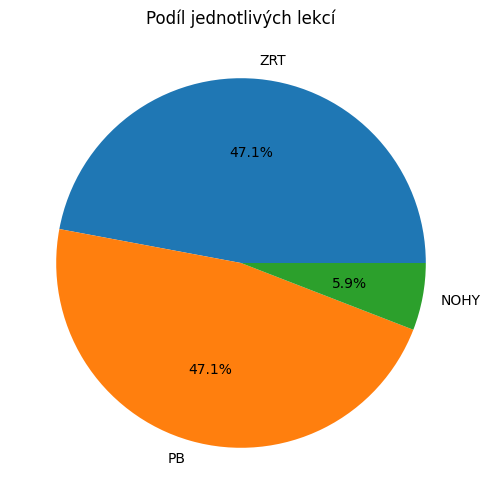

In [11]:
df["summary_norm"].value_counts().plot(kind="pie", autopct="%1.1f%%", figsize=(6,6))
plt.title("Podíl jednotlivých lekcí")
plt.ylabel("")
plt.show()


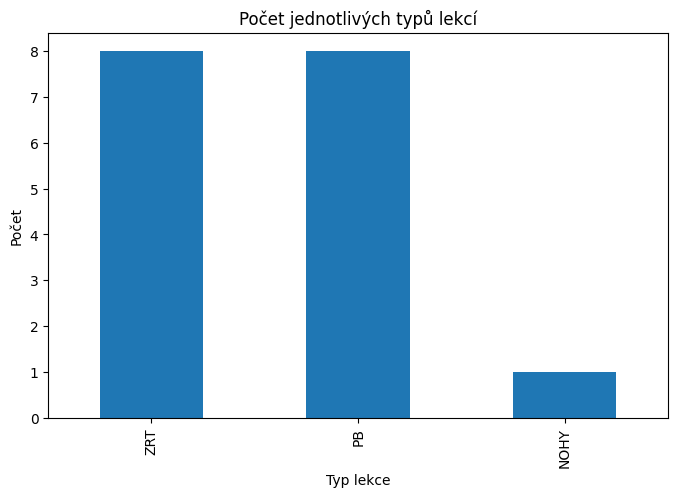

In [12]:
df["summary_norm"].value_counts().plot(kind="bar", figsize=(8,5))
plt.title("Počet jednotlivých typů lekcí")
plt.xlabel("Typ lekce")
plt.ylabel("Počet")
plt.show()


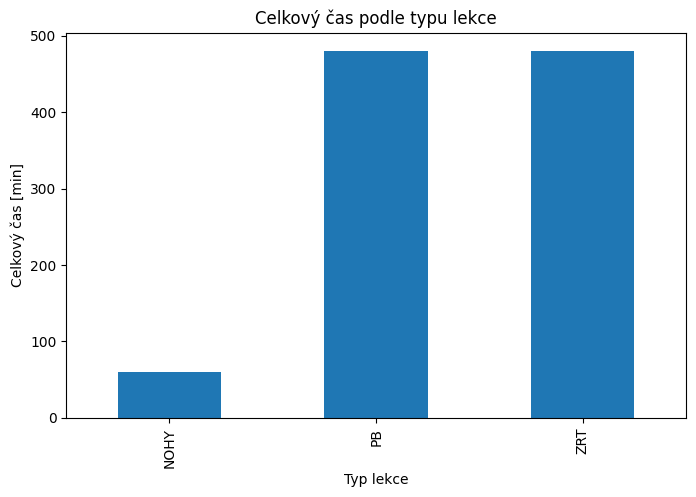

In [13]:
df.groupby("summary_norm")["doba"].sum().plot(kind="bar", figsize=(8,5))
plt.title("Celkový čas podle typu lekce")
plt.ylabel("Celkový čas [min]")
plt.xlabel("Typ lekce")
plt.show()


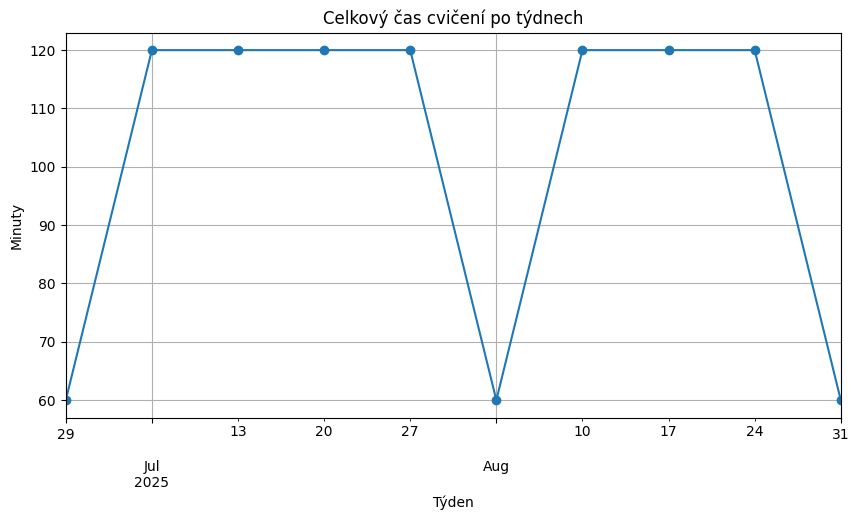

In [8]:
df["week"] = pd.to_datetime(df["date"]).dt.to_period("W")
weekly_minutes = df.groupby("week")["doba"].sum()

weekly_minutes.plot(kind="line", marker="o", figsize=(10,5))
plt.title("Celkový čas cvičení po týdnech")
plt.xlabel("Týden")
plt.ylabel("Minuty")
plt.grid(True)
plt.show()
